In [ ]:
!pip install tflearn==0.5.0
#!pip install certifi==2022.9.24
#!pip install charset-normalizer==2.1.1
!pip install gym==0.11.0
#!pip install idna==3.4
!pip install pyglet==1.5.27
#!pip install requests==2.28.1
#!pip install six==1.16.0
#!pip install urllib3==1.26.12


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 107 kB 4.5 MB/s 
  Created wheel for tflearn: filename=tflearn-0.5.0-py3-none-any.whl size=127299 sha256=122bc77b2174e3d9e46c0352a63754761c3183a006494552d5ba05f46c07176c
  Stored in directory: /root/.cache/pip/wheels/5f/14/2e/1d8e28cc47a5a931a2fb82438c9e37ef9246cc6a3774520271
Successfully built tflearn
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.5 MB 7.1 MB/s 
     |████████████████████████████████| 966 kB 5.8 MB/s 
  Created wheel for gym: filename=gym-0.11.0-py3-none-any.whl size=1588476 sha256=91efc157e67fb00ed1170f498438d59f027d2fc6daa132b9224d53c35cb5ef19
  Stored in directory: /root/.cache/pip/wheels/7c/9e/4f/cb2e795b8075cfc206f4ad30e2be04cb03c3d52dfcc1306cfa
Successfully built gym
  Attempting uninstall: gym
    Found existing installation: gym 0.

In [ ]:
import tflearn
import numpy as np
from collections import deque
import random
import gym
import tflearn
import numpy as np
import tensorflow.compat.v1 as tf
import matplotlib.pyplot as plt

Instructions for updating:
non-resource variables are not supported in the long term


In [ ]:
class ActorNetwork(object):
    def __init__(self, sess, state_dim, action_dim, action_bound, learning_rate, tau, batch_size):
        self.sess = sess
        self.s_dim = state_dim
        self.a_dim = action_dim
        self.action_bound = action_bound
        self.learning_rate = learning_rate
        self.tau = tau
        self.batch_size = batch_size

        # Actor Network
        self.inputs, self.out, self.scaled_out = self.create_actor_network()

        self.network_params = tf.trainable_variables()

        # Target Network
        self.target_inputs, self.target_out, self.target_scaled_out = self.create_actor_network()

        self.target_network_params = tf.trainable_variables()[
                                     len(self.network_params):]

        # Op for periodically updating target network with online network
        # weights
        self.update_target_network_params = \
            [self.target_network_params[i].assign(tf.multiply(self.network_params[i], self.tau) +
                                                  tf.multiply(self.target_network_params[i], 1. - self.tau))
             for i in range(len(self.target_network_params))]

        # This gradient will be provided by the critic network
        self.action_gradient = tf.placeholder(tf.float32, [None, self.a_dim])

        # Combine the gradients here
        self.unnormalized_actor_gradients = tf.gradients(
            self.scaled_out, self.network_params, -self.action_gradient)
        self.actor_gradients = list(map(lambda x: tf.div(x, self.batch_size), self.unnormalized_actor_gradients))

        # Optimization Op
        self.optimize = tf.train.AdamOptimizer(self.learning_rate). \
            apply_gradients(zip(self.actor_gradients, self.network_params))

        self.num_trainable_vars = len(
            self.network_params) + len(self.target_network_params)

    def create_actor_network(self):
        inputs = tflearn.input_data(shape=[None, self.s_dim])
        net = tflearn.fully_connected(inputs, 40)
        net = tflearn.layers.normalization.batch_normalization(net)
        net = tflearn.activations.relu(net)
        net = tflearn.fully_connected(net, 30)
        net = tflearn.layers.normalization.batch_normalization(net)
        net = tflearn.activations.relu(net)
        # Final layer weights are init to Uniform[-3e-3, 3e-3]
        w_init = tflearn.initializations.uniform(minval=-0.003, maxval=0.003)
        out = tflearn.fully_connected(
            net, self.a_dim, activation='tanh', weights_init=w_init)
        # Scale output to -action_bound to action_bound
        scaled_out = tf.multiply(out, self.action_bound)
        return inputs, out, scaled_out

    def train(self, inputs, a_gradient):
        self.sess.run(self.optimize, feed_dict={
            self.inputs: inputs,
            self.action_gradient: a_gradient
        })

    def predict(self, inputs):
        return self.sess.run(self.scaled_out, feed_dict={
            self.inputs: inputs
        })

    def predict_target(self, inputs):
        return self.sess.run(self.target_scaled_out, feed_dict={
            self.target_inputs: inputs
        })

    def update_target_network(self):
        self.sess.run(self.update_target_network_params)

    def get_num_trainable_vars(self):
        return self.num_trainable_vars

In [ ]:
class CriticNetwork(object):

    def __init__(self, sess, state_dim, action_dim, learning_rate, tau, gamma, num_actor_vars):
        self.sess = sess
        self.s_dim = state_dim
        self.a_dim = action_dim
        self.learning_rate = learning_rate
        self.tau = tau
        self.gamma = gamma

        # Create the critic network
        self.inputs, self.action, self.out = self.create_critic_network()

        self.network_params = tf.trainable_variables()[num_actor_vars:]

        # Target Network
        self.target_inputs, self.target_action, self.target_out = self.create_critic_network()

        self.target_network_params = tf.trainable_variables()[(len(self.network_params) + num_actor_vars):]

        # Op for periodically updating target network with online network
        # weights with regularization
        self.update_target_network_params = \
            [self.target_network_params[i].assign(tf.multiply(self.network_params[i], self.tau) \
                                                  + tf.multiply(self.target_network_params[i], 1. - self.tau))
             for i in range(len(self.target_network_params))]

        # Network target (y_i)
        self.predicted_q_value = tf.placeholder(tf.float32, [None, 1])

        # Define loss and optimization Op
        self.loss = tflearn.mean_square(self.predicted_q_value, self.out)
        self.optimize = tf.train.AdamOptimizer(
            self.learning_rate).minimize(self.loss)

        # Get the gradient of the net w.r.t. the action.
        self.action_grads = tf.gradients(self.out, self.action)

    def create_critic_network(self):

        inputs = tflearn.input_data(shape=[None, self.s_dim])
        action = tflearn.input_data(shape=[None, self.a_dim])
        net = tflearn.fully_connected(inputs, 40)
        net = tflearn.layers.normalization.batch_normalization(net)
        net = tflearn.activations.relu(net)

        # Add the action tensor in the 2nd hidden layer
        # Use two temp layers to get the corresponding weights and biases
        t1 = tflearn.fully_connected(net, 30)
        t2 = tflearn.fully_connected(action, 30)

        net = tflearn.activation(
            tf.matmul(net, t1.W) + tf.matmul(action, t2.W) + t2.b, activation='relu')

        # linear layer connected to 1 output representing Q(s,a)
        # Weights are init to Uniform[-3e-3, 3e-3]
        w_init = tflearn.initializations.uniform(minval=-0.003, maxval=0.003)
        out = tflearn.fully_connected(net, 1, weights_init=w_init)
        return inputs, action, out

    def train(self, inputs, action, predicted_q_value):
        return self.sess.run([self.out, self.optimize], feed_dict={
            self.inputs: inputs,
            self.action: action,
            self.predicted_q_value: predicted_q_value
        })

    def predict(self, inputs, action):
        return self.sess.run(self.out, feed_dict={
            self.inputs: inputs,
            self.action: action
        })

    def predict_target(self, inputs, action):
        return self.sess.run(self.target_out, feed_dict={
            self.target_inputs: inputs,
            self.target_action: action
        })

    def action_gradients(self, inputs, actions):
        return self.sess.run(self.action_grads, feed_dict={
            self.inputs: inputs,
            self.action: actions
        })

    def update_target_network(self):
        self.sess.run(self.update_target_network_params)

In [ ]:

class OUNoise:
    def __init__(self, mu, sigma=0.3, theta=.15, dt=1e-2, x0=None):
        self.theta = theta
        self.mu = mu
        self.sigma = sigma
        self.dt = dt
        self.x0 = x0
        self.reset()

    def __call__(self):
        x = self.x_prev + self.theta * (self.mu - self.x_prev) * self.dt + \
            self.sigma * np.sqrt(self.dt) * np.random.normal(size=self.mu.shape)
        self.x_prev = x
        return x

    def reset(self):
        self.x_prev = self.x0 if self.x0 is not None else np.zeros_like(self.mu)

    def __repr__(self):
        return 'OrnsteinUhlenbeckActionNoise(mu={}, sigma={})'.format(self.mu, self.sigma)

In [ ]:
class ReplayBuffer(object):

    def __init__(self, buffer_size, random_seed=123):
        """
        The right side of the deque contains the most recent experiences
        """
        self.buffer_size = buffer_size
        self.count = 0
        self.buffer = deque()
        random.seed(random_seed)

    def add(self, s, a, r, t, s2):
        experience = (s, a, r, t, s2)
        if self.count < self.buffer_size:
            self.buffer.append(experience)
            self.count += 1
        else:
            self.buffer.popleft()
            self.buffer.append(experience)

    def size(self):
        return self.count

    def sample_batch(self, batch_size):
        batch = []

        if self.count < batch_size:
            batch = random.sample(self.buffer, self.count)
        else:
            batch = random.sample(self.buffer, batch_size)

        s_batch = np.array([_[0] for _ in batch])
        a_batch = np.array([_[1] for _ in batch])
        r_batch = np.array([_[2] for _ in batch])
        t_batch = np.array([_[3] for _ in batch])
        s2_batch = np.array([_[4] for _ in batch])

        return s_batch, a_batch, r_batch, t_batch, s2_batch

    def clear(self):
        self.buffer.clear()
        self.count = 0

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.


Reward: -1163 | Episode: 0/300
Reward: -1089 | Episode: 1/300
Reward: -1486 | Episode: 2/300
Reward: -1649 | Episode: 3/300
Reward: -1365 | Episode: 4/300
Reward: -1412 | Episode: 5/300
Reward: -1598 | Episode: 6/300
Reward: -1501 | Episode: 7/300
Reward: -1549 | Episode: 8/300
Reward: -1437 | Episode: 9/300
Reward: -1364 | Episode: 10/300
Reward: -1639 | Episode: 11/300
Reward: -1521 | Episode: 12/300
Reward: -1252 | Episode: 13/300
Reward: -1615 | Episode: 14/300
Reward: -1656 | Episode: 15/300
Reward: -1532 | Episode: 16/300
Reward: -1569 | Episode: 17/300
Reward: -1497 | Episode: 18/300
Reward: -1446 | Episode: 19/300
Reward: -1328 | Episode: 20/300
Reward: -1492 | Episode: 21/300
Reward: -1503 | Episode: 22/300
Reward: -1507 | Episode: 23/300
Reward: -1373 | Episode: 24/300
Reward: -1492 | Episode: 25/300
Reward: -1523 | Episode: 26/300
Reward: -1379 | Episode: 27/300
Reward: -1423 | Episode: 28/300
Reward: -1532 | Episode: 29/300
Reward: -1522 | Episode: 30/300
Reward: -1396 | Ep

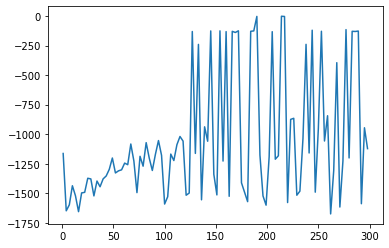

In [ ]:
import gym
import tflearn
import numpy as np
import matplotlib.pyplot as plt


def train(sess, env, actor, critic, actor_noise, buffer_size, min_batch, ep):

    sess.run(tf.global_variables_initializer())

    # Initialize target network weights
    actor.update_target_network()
    critic.update_target_network()

    # Initialize replay memory
    replay_buffer = ReplayBuffer(buffer_size, 0)

    max_episodes = ep
    max_steps = 1000
    score_list = []

    for i in range(max_episodes):

        state = env.reset()
        score = 0

        for j in range(max_steps):


            action = actor.predict(np.reshape(state, (1, actor.s_dim))) + actor_noise()
            next_state, reward, done, info = env.step(action[0])
            replay_buffer.add(np.reshape(state, (actor.s_dim,)), np.reshape(action, (actor.a_dim,)), reward,
                              done, np.reshape(next_state, (actor.s_dim,)))

            # updating the network in batch
            if replay_buffer.size() < min_batch:
                continue

            states, actions, rewards, dones, next_states = replay_buffer.sample_batch(min_batch)
            target_q = critic.predict_target(next_states, actor.predict_target(next_states))

            y = []
            for k in range(min_batch):
                y.append(rewards[k] + critic.gamma * target_q[k] * (1-dones[k]))

            # Update the critic given the targets
            predicted_q_value, _ = critic.train(states, actions, np.reshape(y, (min_batch, 1)))

            # Update the actor policy using the sampled gradient
            a_outs = actor.predict(states)
            grads = critic.action_gradients(states, a_outs)
            actor.train(states, grads[0])

            # Update target networks
            actor.update_target_network()
            critic.update_target_network()

            state = next_state
            score += reward

            if done:
                print('Reward: {} | Episode: {}/{}'.format(int(score), i, max_episodes))
                break

        score_list.append(score)

    return score_list


if __name__ == '__main__':

    with tf.Session() as sess:

        env = gym.make('Pendulum-v0')

        env.seed(0)
        np.random.seed(0)
        tf.set_random_seed(0)

        ep = 300
        tau = 0.001
        gamma = 0.99
        min_batch = 64
        actor_lr = 0.0001
        critic_lr = 0.001
        buffer_size = 1000000

        state_dim = env.observation_space.shape[0]
        action_dim = env.action_space.shape[0]
        action_bound = env.action_space.high

        actor_noise = OUNoise(mu=np.zeros(action_dim))
        actor = ActorNetwork(sess, state_dim, action_dim, action_bound, actor_lr, tau, min_batch)
        critic = CriticNetwork(sess, state_dim, action_dim, critic_lr, tau, gamma, actor.get_num_trainable_vars())

        scores = train(sess, env, actor, critic, actor_noise, buffer_size, min_batch, ep)
        fig = plt.figure()
        plt.plot([i + 1 for i in range(0, ep, 3)], scores[::3])
        fig.savefig('temp.png', dpi=fig.dpi)